# 새 모델 테스트
## 방법
1. 유저 카테고리 선호도를 분산/표준편차를 구한다.
2. 분산이 높은 순으로 나열.
3. 임의의 방법으로 해당 선호도를 x,y좌표계로 변환.
4. 성별은 z축이 되어 구분됨.
5. sequential 모델에 train
6. 좌표 - 선호 카테고리 간의 상관관계 학습,
7. profit!

In [1]:
import pandas as pd

df = pd.read_csv("./survey_data_after.csv", encoding = "euc-kr")
df

,성별,휴양,자연경관,문화유산,액티비티,쇼핑,공연,전시물,경험
0,남성,5,4,4,3,3,3,4,문화유산
1,남성,3,3,3,5,4,4,3,문화유산
2,여성,5,5,4,4,3,5,4,"문화유산, 쇼핑, 전시물"
3,여성,5,1,1,5,3,3,1,쇼핑
4,남성,5,5,4,5,5,5,5,쇼핑
...,...,...,...,...,...,...,...,...,...
144,남성,4,5,4,3,2,2,2,"휴양, 자연경관, 액티비티"
145,남성,3,4,1,4,2,5,5,"휴양, 자연경관, 액티비티"
146,여성,4,5,4,5,2,4,4,"휴양, 자연경관, 액티비티, 쇼핑"
147,여성,4,4,3,3,4,4,3,"휴양, 전시물"


In [2]:
df.loc[:, "성별"]

0      남성
1      남성
2      여성
3      여성
4      남성
       ..
144    남성
145    남성
146    여성
147    여성
148    여성
Name: 성별, Length: 149, dtype: object

In [3]:
import numpy as np
var_arr = np.array([np.var(df.loc[:, "휴양"]), np.var(df.loc[:, "자연경관"]), np.var(df.loc[:, "문화유산"]), np.var(df.loc[:, "액티비티"]), np.var(df.loc[:, "쇼핑"]), np.var(df.loc[:, "공연"]), np.var(df.loc[:, "전시물"])])
var_arr
# 2,6,3,5,4,1,0
#x = 2 * 3 * 4/ y = 6 * 5 * 1

array([0.65870907, 1.19300932, 1.74802937, 1.44434935, 1.23363812,
       1.41498131, 1.59938741])

In [4]:
gender_data = df.loc[:, '성별']
want_data = df.loc[:, '경험']
#exp_data = df.loc[:, '경험']
personal_data = np.zeros(shape = (gender_data.size, 7))

for i in range(gender_data.size):
    for j in range(1, df.loc[i].size - 1):
        personal_data[i][j-1] = df.iloc[i][j]
        

In [5]:
new_input = np.zeros(shape = (gender_data.size, 3))
for i in range(gender_data.size):
    xpos = (personal_data[i][2] * 25 + personal_data[i][3]*5 + personal_data[i][4])/155
    ypos = (personal_data[i][6] * 25 + personal_data[i][5]*5 + personal_data[i][1])/155
    new_input[i] = np.array([xpos, ypos, 0 if gender_data[i] == '여성' else 1])
    

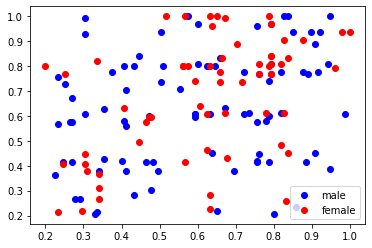

In [38]:
import matplotlib.pyplot as plt

male_x = []
male_y = []
female_x = []
female_y = []

for i in range(gender_data.size):
    if new_input[i, 2] == 0:
        female_x.append(new_input[i, 0])
        female_y.append(new_input[i, 1])
    else :
        male_x.append(new_input[i, 0])
        male_y.append(new_input[i, 1])
        
plt.scatter(male_x, male_y, color = "blue", label = "male")
plt.scatter(female_x, female_y, color = "red", label = "female")
plt.legend()
plt.show()

In [7]:
from ast import literal_eval
dataset = []
target = pd.read_csv("./survey_norm.csv")

for i in range(target['input_data'].size):
    dataset.append( [new_input[i]
                     , np.array(literal_eval(target['want_hot_vec'][i].replace(' ', ',').replace(',,', ',')), dtype = int)])

In [8]:
import random
random.shuffle(dataset)

In [26]:
train_set = dataset[:-30]
test_set = dataset[-30:]

train_input = []
train_target = []

test_input = []
test_target = []
for i in range(len(train_set)):
    train_input.append(train_set[i][0].copy())
    train_target.append(train_set[i][1].copy())

train_input = np.array(train_input)
train_target = np.array(train_target)

for i in range(len(test_set)):
    test_input.append(test_set[i][0].copy())
    test_target.append(test_set[i][1].copy())

test_input = np.array(test_input)
test_target = np.array(test_target)

In [60]:
import tensorflow as tf
from keras import models 
from keras import layers
from keras import regularizers

def build_model(train_len):
    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'sigmoid', input_shape = (train_len, )))
    model.add(layers.Dense(16, activation = 'sigmoid'))
    model.add(layers.Dense(8, activation = 'sigmoid'))
    model.add(layers.Dense(7))
    
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    #model.compile(optimizer = 'adam', loss='mse', metrics=['accuracy'])
    return model

In [61]:
k = 4
num_val_sample = len(train_input) // k
num_epochs = 200
all_mae_histories = []

np.random.shuffle(train_input)
for i in range(k):
    val_input = train_input[i * num_val_sample : (i+1) * num_val_sample]
    val_target = train_target[i * num_val_sample : (i+1) * num_val_sample]
    
    partial_train_input = np.concatenate(
        [train_input[:i * num_val_sample],
         train_input[(i + 1) * num_val_sample:]], axis = 0)
    partial_train_target = np.concatenate(
        [train_target[:i * num_val_sample],
         train_target[(i + 1) * num_val_sample:]], axis = 0)
    
    model = build_model(partial_train_input.shape[1])
    history = model.fit(partial_train_input, partial_train_target, 
                        validation_data = (val_input, val_target), epochs = num_epochs, 
              batch_size = 4, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [62]:
average_mae_history = [np.mean([x[i] for  x in all_mae_histories]) for i in range(num_epochs)]

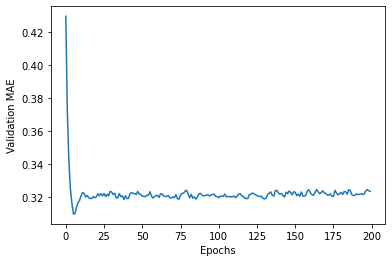

In [63]:
#smooth_mae_history = smooth_curve(average_mae_history[10:])

#plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

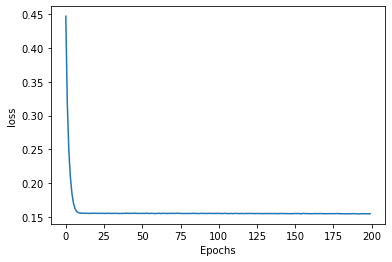

In [64]:
history_dict = history.history

plt.plot(range(num_epochs), history_dict['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [59]:
model = build_model(train_input.shape[1])
model.fit(train_input, train_target, epochs = 150, batch_size = 4, verbose = 0)
test_mse, test_mae = model.evaluate(test_input, test_target)
print(test_mse, test_mae)

1/1 [==============================] - 0s 58ms/step - loss: 0.1627 - mean_absolute_error: 0.3176
0.1626698225736618 0.3176373541355133


In [65]:
result_df = pd.DataFrame(columns = ['input_data', 'target', 'result'])
pred_result = model.predict(test_input)

for i in range(pred_result.shape[0]):
    result_df.loc[i] = [test_input[i], test_target[i], pred_result[i]]

In [66]:
last_out = []
for i in range(pred_result.shape[0]):
    temp = []
    for j in range(pred_result.shape[1]):
        if pred_result[i][j] > 0.5:
            temp.append(1)
        else:
            temp.append(0)
            
    if np.all(np.array(temp) == 0):
        temp[np.argmax(np.array(temp))] = 1
        
    last_out.append(temp)
last_out = np.array(last_out)

In [67]:
collect_cnt = 0
for i in range(pred_result.shape[0]):
    for j in range(pred_result.shape[1]):
        if last_out[i][j] == test_target[i][j]:
            collect_cnt += 1

In [68]:
print((collect_cnt / 210) * 100)

76.66666666666667


In [69]:
for i in range(pred_result.shape[0]):
    print(test_input[i], ', ', test_target[i], ', ', last_out[i])

[0.78709677 0.74193548 1.        ] ,  [0 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.72258065 0.60645161 1.        ] ,  [0 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.78709677 1.         0.        ] ,  [1 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.56774194 0.41290323 0.        ] ,  [1 0 0 0 1 0 0] ,  [1 1 0 0 0 0 0]
[0.33548387 0.81935484 0.        ] ,  [0 0 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.63870968 0.4516129  1.        ] ,  [1 0 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.92258065 0.93548387 1.        ] ,  [0 1 1 0 0 0 1] ,  [1 1 0 0 0 0 0]
[0.75483871 0.41935484 1.        ] ,  [1 1 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.30322581 0.99354839 1.        ] ,  [1 1 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[0.78709677 0.6        1.        ] ,  [1 0 1 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.98709677 0.60645161 1.        ] ,  [1 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.76129032 0.44516129 1.        ] ,  [0 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.59354839 0.60645161 1.        ] ,  [1 1 0 0 0 0 0] ,  [1 1 0 0 0 0 0]
[0.67096774 0.61290323 0.        ] ,  [1 0 0 1 1 0 